# BT4012 Group Project - XGBoost
# Vehicle Insurance Claim Fraud Detection

## Loading libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import re
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve, auc
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
import shap

c:\Users\Chen Xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_columns', None)

## Reading Train Data

In [ ]:
# Getting data from Google Drive
!pip install gdown
file_id = "1SCo7qnlCQdA3mIud9rIR9cw79RTfPYhJ"
!gdown {file_id} -O fraud_oracle.csv

# Extracting Train and Test Datasets
data = pd.read_csv('fraud_oracle.csv')
data.head()


[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Chen Xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SCo7qnlCQdA3mIud9rIR9cw79RTfPYhJ
To: c:\Users\Chen Xiang\Downloads\fraud_oracle.csv

  0%|          | 0.00/3.62M [00:00<?, ?B/s]
 43%|████▎     | 1.57M/3.62M [00:00<00:00, 13.6MB/s]
 87%|████████▋ | 3.15M/3.62M [00:00<00:00, 12.6MB/s]
100%|██████████| 3.62M/3.62M [00:00<00:00, 12.9MB/s]


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [5]:
# Information about our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [6]:
# Fraud and non-Fraud split
data['FraudFound_P'].value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

# Data Preprocessing

## Original Columns

* **Month** - The month in which the accident occurred.
* **WeekOfMonth** - The week of the month in which the accident occurred.
* **DayOfWeek** - The day of the week on which the accident occurred.
* **Make** - The manufacturer of the vehicle involved in the claim & accident.
* **AccidentArea** - The area where the accident occurred (e.g., urban, rural).
* **DayOfWeekClaimed** - The day of the week on which the insurance claim was made.
* **MonthClaimed** - The month in which the insurance claim was made.
* **WeekOfMonthClaimed** - The week of the month in which the insurance claim was made.
* **Sex** - The gender of the policyholder.
* **MaritalStatus** - The material status of the policyholder.
* **Age** - The age of the driver involved in the accident.
* **Fault** - Indicates whether the policyholder was at fault in the accident.
* **PolicyType** - The type of insurance policy (e.g., comprehensive, third-party).
* **VehicleCategory** - The category of the vehicle (e.g., sedan, SUV).
* **VehiclePrice** - The price of vehicle.
* **FraudFound_P** - Indicates whether fraud was detected in the insurance claim.
* **PolicyNumber** - Currently hidden and labelled as index of the row.
* **RepNumber** - The unique identifier for the insurance representative handling the claim.
* **Deductible** - The amount that the policy holder must pay out of pocket before the insurance company pays the remaining costs.
* **DriverRating** - The rating of the driver, often based on driving history or other factors.
* **Days_Policy_Accident** - The number of days since the policy was issued until the accident occurred.
* **Days_Policy_Claim** - The number of days since the policy was issued until the claim was made.
* **PastNumberOfClaims** - The number of claims previously made by the policyholder.
* **AgeOfVehicle** - The age of the vehicle involved in the claim.
* **AgeOfPolicyHolder** - The age of the policyholder.
* **PoliceReportFiled** - Indicates whether a police report was filed for the accident.
* **WitnessPresent** - Indicates whether a witness was present at the scene of the accident.
* **AgentType** - The type of insurance agent handling the policy (e.g., internal, external)
* **NumberOfSuppliments** - The number of supplementary documents or claims related to the main claim, categorized into ranges.
* **AddressChange_Claim** - Indicates whether the address of the policyholder was changed at the time of the claim, categorized into ranges.
* **NumberOfCars** - The number of cars insured under the policy, categorized into ranges.
* **Year** - The year in which the accident occured.
* **BasePolicy** - The base policy type (e.g., Liability, Collision, All Perils).

## Columns Added

* **AgeMatchesRange** - Whether the **Age** of the driver falls within the age range of **AgeOfPolicyHolder**

## Looking at Categorical Variables:

In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


##### There are no missing values in the dataset.

In [8]:
# Unique categories in categorical columns
for col in data.select_dtypes(include=['object']).columns:
    print(f"{col}: {data[col].unique()}")

Month: ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']
DayOfWeek: ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']
Make: ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']
AccidentArea: ['Urban' 'Rural']
DayOfWeekClaimed: ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']
MonthClaimed: ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']
Sex: ['Female' 'Male']
MaritalStatus: ['Single' 'Married' 'Widow' 'Divorced']
Fault: ['Policy Holder' 'Third Party']
PolicyType: ['Sport - Liability' 'Sport - Collision' 'Sedan - Liability'
 'Utility - All Perils' 'Sedan - All Perils' 'Sedan - Collision'
 'Utility - Collision' 'Utility - Liability' 'Sport - All Perils']
VehicleCategory: ['Sport' 'Utility' 'Sedan']
VehiclePrice: ['more than 69000' '20000 to 29000' '30000 to 39000' 'less t

##### We identified that some categorical columns (DayOfWeekClaimed and MonthClaimed) contain invalid '0' values. We will thus replace these entries with NaN to mark them as missing.


In [9]:
# Replace '0' with NaN for affected columns
columns_with_zeros = ['DayOfWeekClaimed', 'MonthClaimed']
for col in columns_with_zeros:
    data[col] = data[col].replace('0', np.nan)

# Check the number of missing values in affected columns
print(data[columns_with_zeros].isnull().sum())

# Drop rows where these columns have missing values
data.dropna(subset=['DayOfWeekClaimed', 'MonthClaimed'], inplace=True)

# Verify that there are no more missing values in these columns
print(data[['DayOfWeekClaimed', 'MonthClaimed']].isnull().sum())

# Reset index on data
data.reset_index(drop=True, inplace=True)
print(f'Length of data: {len(data)}')

DayOfWeekClaimed    1
MonthClaimed        1
dtype: int64
DayOfWeekClaimed    0
MonthClaimed        0
dtype: int64
Length of data: 15419


##### Since there was only one missing value in both DayOfWeekClaimed and MonthClaimed, we decided to drop the affected row to simplify the preprocessing.

## Looking at Numerical Variables:

In [10]:
# Values for numerical columns
for col in data.select_dtypes(include=['int64', 'float64']).columns:
    print(f"{col}: {data[col].unique()}")

WeekOfMonth: [5 3 2 4 1]
WeekOfMonthClaimed: [1 4 2 3 5]
Age: [21 34 47 65 27 20 36  0 30 42 71 52 28 61 38 41 32 40 63 31 45 60 39 55
 35 44 72 29 37 59 49 50 26 48 64 33 74 23 25 56 16 68 18 51 22 53 46 43
 57 54 69 67 19 78 77 75 80 58 73 24 76 62 79 70 17 66]
FraudFound_P: [0 1]
PolicyNumber: [    1     2     3 ... 15418 15419 15420]
RepNumber: [12 15  7  4  3 14  1 13 11 16  6  2  8  5  9 10]
Deductible: [300 400 500 700]
DriverRating: [1 4 3 2]
Year: [1994 1995 1996]


##### For numerical columns, the Age column contains an invalid value of 0, which likely represents missing or erroneous data. Additionally, the PolicyNumber column appears to be a unique identifier with no predictive relevance, so it can be dropped during feature selection to streamline the modeling process.

### Examining **Age**:

In [11]:
# Filter rows where Age is 0
age_zero_rows = data[data['Age'] == 0]

# Count the number of rows where Age is 0
age_zero_count = age_zero_rows.shape[0]

# Examine the 'AgeOfPolicyHolder' column for these rows
age_zero_policy_holder_values = age_zero_rows['AgeOfPolicyHolder'].unique()

age_zero_count, age_zero_policy_holder_values

(319, array(['16 to 17'], dtype=object))

##### There are 319 rows where Age = 0 and for every row with Age = 0, they have a Policy Holder between 16 and 17 years old. This looked suspicious and we decided to investigate the relationship between 'Age' and 'AgeOfPolicyHolder'.

In [12]:
# Define the mapping of AgeOfPolicyHolder ranges
age_ranges = {
    '16 to 17': (16, 17),
    '18 to 20': (18, 20),
    '21 to 25': (21, 25),
    '26 to 30': (26, 30),
    '31 to 35': (31, 35),
    '36 to 40': (36, 40),
    '41 to 50': (41, 50),
    '51 to 65': (51, 65),
    'over 65': (66, 80)  # Max Age is 80 as seen in the dataset
}

# Check if Age matches the range in AgeOfPolicyHolder
def is_age_matching(row):
    if row['AgeOfPolicyHolder'] in age_ranges:
        min_age, max_age = age_ranges[row['AgeOfPolicyHolder']]
        return min_age <= row['Age'] <= max_age
    return False

data['AgeMatchesRange'] = data.apply(is_age_matching, axis=1).astype(int)

# Count the mismatches
age_mismatch_count = data['AgeMatchesRange'].value_counts()

# Display only the Age and AgeOfPolicyHolder columns for mismatched rows
mismatched_rows = data[data['AgeMatchesRange'] == False]
mismatched_rows_filtered = mismatched_rows[['Age', 'AgeOfPolicyHolder']]

print(age_mismatch_count, mismatched_rows_filtered)

1    8178
0    7241
Name: AgeMatchesRange, dtype: int64        Age AgeOfPolicyHolder
0       21          26 to 30
4       27          31 to 35
5       20          21 to 25
7        0          16 to 17
8       30          31 to 35
...    ...               ...
15410   42          36 to 40
15411   28          31 to 35
15415   30          31 to 35
15416   24          26 to 30
15418   21          26 to 30

[7241 rows x 2 columns]


#####Approximately 46.96% of the data, or 7,241 out of 15,419 rows, have an Age value that does not match the range specified in AgeOfPolicyHolder. This significant percentage suggests systemic discrepancies rather than simple typos, likely indicating that the driver is different from the policyholder. Assuming AgeOfPolicyHolder is more reliable, we address invalid Age values by replacing 0 with the mean of the corresponding interval, specifically 16.5 for the range 16 to 17.

In [13]:
# Replace Age = 0 with the average of the 16 - 17 age range: 16.5
data['Age'] = data['Age'].astype(float)
data.loc[data['Age'] == 0, 'Age'] = 16.5

### For the next few features, we convert them from categorical non-numeric

### Examining **NumberOfCars**:



In [14]:
data["NumberOfCars"].value_counts()

1 vehicle      14315
2 vehicles       709
3 to 4           372
5 to 8            21
more than 8        2
Name: NumberOfCars, dtype: int64

##### We can convert number of cars into a respective value as it is ordinal data. For those with a range, we will replace them with the minimum of the range

In [15]:
def convert_number_of_cars(value):
    if value == '1 vehicle':
        return 1
    elif value == '2 vehicles':
        return 2
    elif value == '3 to 4':
        return 3 # Minimum of the range
    elif value == '5 to 8':
        return 5 # Minimum of the range
    elif value == 'more than 8':
        return 9
    else:
        return None  # Handle unexpected values

# Apply the conversion function
data['NumberOfCars'] = data['NumberOfCars'].apply(convert_number_of_cars)

### Examining **AddressChange_Claim**:

In [16]:
data['AddressChange_Claim'].value_counts()

no change         14323
4 to 8 years        631
2 to 3 years        291
1 year              170
under 6 months        4
Name: AddressChange_Claim, dtype: int64

#####We can change it into a numeric column, repalcing those with a range into the mean of the range

In [17]:
def convert_address_change_claim(value):
    if value == 'no change':
        return 0
    elif value == 'under 6 months':
        return 0.5/2 # Average of the range
    elif value == '1 year':
        return 1
    elif value == '2 to 3 years':
        return (2+3)/2 # Average of the range
    elif value == '4 to 8 years':
        return (4+8)/2 # Average of the range
    else:
        return None  # Handle unexpected values

# Apply the conversion function
data['AddressChange_Claim'] = data['AddressChange_Claim'].apply(convert_address_change_claim)

### Examining **NumberOfSuppliments**:

In [18]:
data['NumberOfSuppliments'].value_counts()

none           7046
more than 5    3867
1 to 2         2489
3 to 5         2017
Name: NumberOfSuppliments, dtype: int64

In [19]:
def convert_num_supplements(value):
    if value == 'none':
        return 0
    elif value == '1 to 2':
        return 1 # Minimum of the range
    elif value == '3 to 5':
        return 3 # Minimum of the range
    elif value == 'more than 5':
        return 6 # Minimum of the range
    else:
        return None  # Handle unexpected values

data['NumberOfSuppliments'] = data['NumberOfSuppliments'].apply(convert_num_supplements)

### Examining **AgeOfVehicle**:

In [20]:
data['AgeOfVehicle'].value_counts()

7 years        5807
more than 7    3981
6 years        3448
5 years        1357
new             372
4 years         229
3 years         152
2 years          73
Name: AgeOfVehicle, dtype: int64

In [21]:
def convert_age_of_vehicle(value): # Minimum of the range
    if value == 'new':
        return 0
    elif value == '2 years':
        return 2
    elif value == '3 years':
        return 3
    elif value == '4 years':
        return 4
    elif value == '5 years':
        return 5
    elif value == '6 years':
        return 6
    elif value == '7 years':
        return 7
    elif value == 'more than 7':
        return 8
    else:
        return None  # Handle unexpected values

data['AgeOfVehicle'] = data['AgeOfVehicle'].apply(convert_age_of_vehicle)

### Examining **PastNumberOfClaims**:

In [22]:
data['PastNumberOfClaims'].value_counts()

2 to 4         5485
none           4351
1              3573
more than 4    2010
Name: PastNumberOfClaims, dtype: int64

In [23]:
def convert_past_num_of_claims(value):
    if value == 'none':
        return 0
    elif value == '1':
        return 1
    elif value == '2 to 4':
        return 2
    elif value == 'more than 4':
        return 5
    else:
        return None  # Handle unexpected values

data['PastNumberOfClaims'] = data['PastNumberOfClaims'].apply(convert_past_num_of_claims)

### Examining **VehiclePrice**:

In [24]:
data['VehiclePrice'].value_counts()

20000 to 29000     8079
30000 to 39000     3533
more than 69000    2163
less than 20000    1096
40000 to 59000      461
60000 to 69000       87
Name: VehiclePrice, dtype: int64

##### We replace vehicle prices with the mean of the range since it is a huge range, and more than 69000 with 69000

In [25]:
def convert_vehicle_price(value):
    if value == 'less than 20000':
        return 20000/2
    elif value == '20000 to 29000':
        return (20000 + 29000)/2
    elif value == '30000 to 39000':
        return (30000+39000)/2
    elif value == '40000 to 59000':
        return (40000+59000)/2
    elif value == '60000 to 69000':
        return (60000+69000)/2
    elif value == 'more than 69000':
        return 69001
    else:
        return None  # Handle unexpected values

data['VehiclePrice'] = data['VehiclePrice'].apply(convert_vehicle_price)

### Examining **Days_Policy_Accident**

In [26]:
data['Days_Policy_Accident'].value_counts()

more than 30    15246
none               55
8 to 15            55
15 to 30           49
1 to 7             14
Name: Days_Policy_Accident, dtype: int64

##### We shall replace the ranges with the minimum for consistency.

In [27]:
def convert_days_policy_accident(value):
    if value == 'none':
        return 0
    elif value == '1 to 7':
        return 1
    elif value == '8 to 15':
        return 8
    elif value == '15 to 30':
        return 15
    elif value == 'more than 30':
        return 31
    else:
        return None  # Handle unexpected values

data['Days_Policy_Accident'] = data['Days_Policy_Accident'].apply(convert_days_policy_accident)

### Examining **Days_Policy_Claim**

In [28]:
data['Days_Policy_Claim'].value_counts()

more than 30    15342
15 to 30           56
8 to 15            21
Name: Days_Policy_Claim, dtype: int64

##### We will replace the ranges with the minimum values.

In [29]:
def convert_days_policy_claim(value):
    if value == '8 to 15':
        return 8
    elif value == '15 to 30':
        return 15
    elif value == 'more than 30':
        return 31
    else:
        return None  # Handle unexpected values

data['Days_Policy_Claim'] = data['Days_Policy_Claim'].apply(convert_days_policy_claim)

### Examining **AgeOfPolicyHolder**

In [30]:
data['AgeOfPolicyHolder'].value_counts()

31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
26 to 30     613
over 65      508
16 to 17     319
21 to 25     108
18 to 20      15
Name: AgeOfPolicyHolder, dtype: int64

### We will replace the ranges with the minimum values.

In [31]:
def convert_age_of_policy_holder(value): # Minimum of the range
    if value == '16 to 17':
        return 16
    elif value == '18 to 20':
        return 18
    elif value == '21 to 25':
        return 21
    elif value == '26 to 30':
        return 26
    elif value == '31 to 35':
        return 31
    elif value == '36 to 40':
        return 36
    elif value == '41 to 50':
        return 41
    elif value == '51 to 65':
        return 51
    elif value == 'over 65':
        return 66
    else:
        return None  # Handle unexpected values

data['AgeOfPolicyHolder'] = data['AgeOfPolicyHolder'].apply(convert_age_of_policy_holder)

### Examining at **Yes**/**No** Columns: **PoliceReportFiled** & **WitnessPresent**

In [32]:
print(data['PoliceReportFiled'].value_counts())
print(data['WitnessPresent'].value_counts())

No     14991
Yes      428
Name: PoliceReportFiled, dtype: int64
No     15332
Yes       87
Name: WitnessPresent, dtype: int64


##### We can convert Yes to 1, and No to 0 for these 2 columns

In [33]:
data['PoliceReportFiled'] = data['PoliceReportFiled'].map({'Yes': 1, 'No': 0})
data['WitnessPresent'] = data['WitnessPresent'].map({'Yes': 1, 'No': 0})

### Examining **AgentType**

In [34]:
data['AgentType'].value_counts()

External    15178
Internal      241
Name: AgentType, dtype: int64

##### We can transform this into a new boolean column called **AgentTypeExternal**, then drop the old column

In [35]:
data['AgentTypeExternal'] = data['AgentType'].map({'External': 1, 'Internal': 0})
data = data.drop('AgentType', axis=1)

### Examining **Fault**

In [36]:
data["Fault"].value_counts()

Policy Holder    11229
Third Party       4190
Name: Fault, dtype: int64

##### We can transform this into a new binary column called **Is_Policy_Holder_Fault**, then drop the old column

In [37]:
data['Is_Policy_Holder_Fault'] = data['Fault'].map({'Policy Holder': 1, 'Third Party': 0})
data = data.drop('Fault', axis=1)

### Examining **AccidentArea**

In [38]:
data["AccidentArea"].value_counts()

Urban    13822
Rural     1597
Name: AccidentArea, dtype: int64

##### We can transform this into a binary column called **Is_Urban**, then drop the original column

In [39]:
data['Is_Urban'] = data['AccidentArea'].map({'Urban': 1, 'Rural': 0})
data = data.drop('AccidentArea', axis=1)

### Examining **Sex**

In [40]:
data["Sex"].value_counts()

Male      12999
Female     2420
Name: Sex, dtype: int64

##### We can transform this into a binary column called **Is_Male**, then drop the original column

In [41]:
data['Is_Male'] = data['Sex'].map({'Male': 1, 'Female': 0})
data = data.drop('Sex', axis=1)

### Checking the data after Data-Preprocessing

In [42]:
data.head()

,Month,WeekOfMonth,DayOfWeek,Make,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,MaritalStatus,Age,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,AgeMatchesRange,AgentTypeExternal,Is_Policy_Holder_Fault,Is_Urban,Is_Male
0,Dec,5,Wednesday,Honda,Tuesday,Jan,1,Single,21.0,Sport - Liability,Sport,69001.0,0,1,12,300,1,31,31,0,3,26,0,0,0,1.0,3,1994,Liability,0,1,1,1,0
1,Jan,3,Wednesday,Honda,Monday,Jan,4,Single,34.0,Sport - Collision,Sport,69001.0,0,2,15,400,4,31,31,0,6,31,1,0,0,0.0,1,1994,Collision,1,1,1,1,1
2,Oct,5,Friday,Honda,Thursday,Nov,2,Married,47.0,Sport - Collision,Sport,69001.0,0,3,7,400,3,31,31,1,7,41,0,0,0,0.0,1,1994,Collision,1,1,1,1,1
3,Jun,2,Saturday,Toyota,Friday,Jul,1,Married,65.0,Sedan - Liability,Sport,24500.0,0,4,4,400,2,31,31,1,8,51,1,0,6,0.0,1,1994,Liability,1,1,0,0,1
4,Jan,5,Monday,Honda,Tuesday,Feb,2,Single,27.0,Sport - Collision,Sport,69001.0,0,5,3,400,1,31,31,0,5,31,0,0,0,0.0,1,1994,Collision,0,1,0,1,0


# Feature Engineering

## New Columns Added

1. **Claim_Processing_Time** - Difference between date of accident and date of claim made
2. **Policy_Type_Vehicle_Category** - Discrepancies between vehicle category and type of policy bought, eg Sport vehicle category buying Sedan policy (1 denotes lower vehicle category buying a higher policy type, while -1 denotes a higher vehicle category buying a lower policy type)
3. **Low_Price_Highly_Insured** - 2 lowest vehicle_price with most expensive policy bought (all perils)
4. **PolicyHolder_Aggressiveness** - ratio of PastNumberOfClaims and DriverRating, also with fault accounted for
5. **Vehicle_Value_to_Age_Ratio** - Ratio of Vehicle_Price to AgeOfVehicle
6. **Vehicle_Value_to_Deductable_Ratio** - ratio of vehicle price to deductible amount
7. **Has_Claimed_Before**
8. **Severe_Accident** - if police report filed and witness present

## Columns Dropped
* **WeekOfMonth** - The week of the month in which the accident occurred.
* **WeekOfMonthClaimed** - The week of the month in which the insurance claim was made.
* **PolicyNumber** - Currently hidden and labelled as index of the row.

In [43]:
# Feature Engineering

# Feature 1
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Map for days of the week to their numerical values
day_of_week_map = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,
                   'Thursday': 4, 'Friday': 5, 'Saturday': 6}

def calculate_accident_date(row):
    month = month_map[row['Month']]
    week_of_month = row['WeekOfMonth']
    day_of_week = day_of_week_map[row['DayOfWeek']]
    year = row['Year']

    # Get the accident_date
    first_day = datetime(year, month, 1)
    week_of_accident = first_day + timedelta(weeks=(week_of_month - 1))
    accident_date = week_of_accident + timedelta(days=(day_of_week - (week_of_accident.weekday()+1)%7))

    return accident_date

def calculate_claim_date(row):
    accident_month = month_map[row['Month']]
    accident_year = row['Year']

    claim_month = month_map[row['MonthClaimed']]
    claim_week = row['WeekOfMonthClaimed']
    claim_day_of_week = day_of_week_map[row['DayOfWeekClaimed']]

    # If claim month is Jan, while accident month is Dec, claim year should be the year after
    if claim_month < accident_month:
      claim_year = accident_year + 1
    else:
      claim_year = accident_year

    # Get the claim date
    first_day = datetime(claim_year, claim_month, 1)
    week_of_claim = first_day + timedelta(weeks=(claim_week - 1))
    claim_date = week_of_claim + timedelta(days=(claim_day_of_week - (week_of_claim.weekday()+1)%7))

    return claim_date

# Intermediate Steps:
data['Accident_Date'] = data.apply(calculate_accident_date, axis=1)
data['Claim_Date'] = data.apply(calculate_claim_date, axis=1)

data['Claim_Processing_Time'] = (data['Claim_Date'] - data['Accident_Date']).dt.days

# Drop Intermediate Columns:
data = data.drop(['Accident_Date', 'Claim_Date'], axis=1)

# Feature 2:
def check_policy_vehicle_discrepancy(row):
    policy_vehicle_category = row['PolicyType'].split(' - ')[0]
    category_order = {'Utility': 1, 'Sedan': 2, 'Sports': 3}
    actual_category = category_order.get(row['VehicleCategory'], 0)
    policy_category = category_order.get(policy_vehicle_category, 0)

    if actual_category < policy_category:
        return 1
    elif actual_category > policy_category:
        return -1
    else:
        return 0

data['Policy_Type_Vehicle_Category'] = data.apply(check_policy_vehicle_discrepancy, axis=1)

# Feature 3
low_price_categories = ['less than 20000', '20000 to 29000']

data['Low_Price_Highly_Insured'] = ((data['VehiclePrice'].isin(low_price_categories)) &
                                    (data['PolicyType'].str.contains('All Perils'))).astype(int)

# Feature 4
def calculate_aggressiveness(row):
    max_rating = 5
    aggressiveness = row['PastNumberOfClaims'] * (max_rating - row['DriverRating'] + 1)
    if row['Is_Policy_Holder_Fault'] == 'Yes':
        aggressiveness *= 1.5
    return aggressiveness

data['PolicyHolder_Aggressiveness'] = data.apply(calculate_aggressiveness, axis=1)

#Feature 5
data['Vehicle_Value_to_Age_Ratio'] = data['VehiclePrice'] / (data['AgeOfVehicle'] + 1)

#Feature 6
data['Vehicle_Value_to_Deductible_Ratio'] = data['VehiclePrice'] / (data['Deductible'] + 1)

#Feature 7
data['Has_Claimed_Before'] = (data['PastNumberOfClaims'] != 'None').astype(int)

#Feature 8
data['Severe_Accident'] = ((data['PoliceReportFiled'] == 1) & (data['WitnessPresent'] == 1)).astype(int)

# Drop Unused Columns
data = data.drop(['WeekOfMonth', 'WeekOfMonthClaimed', 'PolicyNumber'], axis=1)

### One-Hot Encoding For Remaining Categorical Columns:
* **Month**
* **DayOfWeek**
* **Make**
* **DayOfWeekClaimed**
* **MonthClaimed**
* **MaritalStatus**
* **PolicyType**
* **VehicleCategory**
* **BasePolicy**

In [44]:
# List of columns
columns_to_encode = ['Make', 'MaritalStatus', 'PolicyType', 'VehicleCategory', 'BasePolicy', 'Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed']

# One-hot encode columns_to_encode (Left as uint8 [unsigned 8-bit integers] as it is memory efficient)
data = pd.get_dummies(data, columns=columns_to_encode, drop_first=False)

In [45]:
data.head()

,Age,VehiclePrice,FraudFound_P,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,AgeMatchesRange,AgentTypeExternal,Is_Policy_Holder_Fault,Is_Urban,Is_Male,Claim_Processing_Time,Policy_Type_Vehicle_Category,Low_Price_Highly_Insured,PolicyHolder_Aggressiveness,Vehicle_Value_to_Age_Ratio,Vehicle_Value_to_Deductible_Ratio,Has_Claimed_Before,Severe_Accident,Make_Accura,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ferrari,Make_Ford,Make_Honda,Make_Jaguar,Make_Lexus,Make_Mazda,Make_Mecedes,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Porche,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,DayOfWeekClaimed_Friday,DayOfWeekClaimed_Monday,DayOfWeekClaimed_Saturday,DayOfWeekClaimed_Sunday,DayOfWeekClaimed_Thursday,DayOfWeekClaimed_Tuesday,DayOfWeekClaimed_Wednesday,MonthClaimed_Apr,MonthClaimed_Aug,MonthClaimed_Dec,MonthClaimed_Feb,MonthClaimed_Jan,MonthClaimed_Jul,MonthClaimed_Jun,MonthClaimed_Mar,MonthClaimed_May,MonthClaimed_Nov,MonthClaimed_Oct,MonthClaimed_Sep
0,21.0,69001.0,0,12,300,1,31,31,0,3,26,0,0,0,1.0,3,1994,0,1,1,1,0,6,0,0,0,17250.250000,229.239203,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,34.0,69001.0,0,15,400,4,31,31,0,6,31,1,0,0,0.0,1,1994,1,1,1,1,1,5,0,0,0,9857.285714,172.072319,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,47.0,69001.0,0,7,400,3,31,31,1,7,41,0,0,0,0.0,1,1994,1,1,1,1,1,13,0,0,3,8625.125000,172.072319,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,65.0,24500.0,0,4,400,2,31,31,1,8,51,1,0,6,0.0,1,1994,1,1,0,0,1,20,1,0,4,2722.222222,61.097257,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,27.0,69001.0,0,3,400,1,31,31,0,5,31,0,0,0,0.0,1,1994,0,1,0,1,0,15,0,0,0,11500.166667,172.072319,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


# Prediction Validation

## Splitting the Data

In [46]:
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data into train+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

## Training the Model

In [47]:
# Calculate class weights
class_0_weight = 1
class_1_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Map weights to the training labels
sample_weights = y_train.map({0: class_0_weight, 1: class_1_weight})

# Initialize XGBoost with class weights
xgb_model_custom = XGBClassifier(
    random_state=42,
    scale_pos_weight=class_1_weight,  # Use calculated weight for the positive class
    use_label_encoder=False,  # Suppress label encoder warnings
    eval_metric='logloss'  # Default evaluation metric
)

# Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'max_depth': [8, 10, 12],
#     'learning_rate': [0.01, 0.05],
#     'n_estimators': [300, 500],
#     'subsample': [0.8, 1],
#     'colsample_bytree': [0.8, 1]
# }
### The best parameters we found.
param_grid_xgb_custom = {
    'colsample_bytree': [1],
    'learning_rate': [0.01],
    'max_depth': [8],
    'n_estimators': [500],
    'subsample': [0.8]
    }

# Use GridSearchCV to tune hyperparameters
grid_search_xgb_custom = GridSearchCV(
    estimator=xgb_model_custom,
    param_grid=param_grid_xgb_custom,
    scoring='f1',  
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search on the training data
grid_search_xgb_custom.fit(X_train, y_train)

# Get the best model after tuning
best_xgb_model_custom = grid_search_xgb_custom.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Chen Xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Validating the Model

In [48]:
# Evaluate the model on the training set
train_predictions = best_xgb_model_custom.predict_proba(X_train)[:, 1]
train_roc_auc = roc_auc_score(y_train, train_predictions)
print(f'Training ROC AUC: {train_roc_auc}')
train_predictions_class = best_xgb_model_custom.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions_class)
print(f'Training Accuracy: {train_accuracy}')

Training ROC AUC: 0.993659201743034
Training Accuracy: 0.8724462220300508


In [49]:
# Evaluate the model on the validation set
val_predictions = best_xgb_model_custom.predict_proba(X_val)[:, 1]
val_roc_auc = roc_auc_score(y_val, val_predictions)
print(f'Validation ROC AUC: {val_roc_auc}')
print("Best parameters:", grid_search_xgb_custom.best_params_)

val_predictions_class = best_xgb_model_custom.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions_class)
print(f'Validation Accuracy: {val_accuracy}')

Validation ROC AUC: 0.8448466833065311
Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Validation Accuracy: 0.8278210116731517


## Finding Important Features

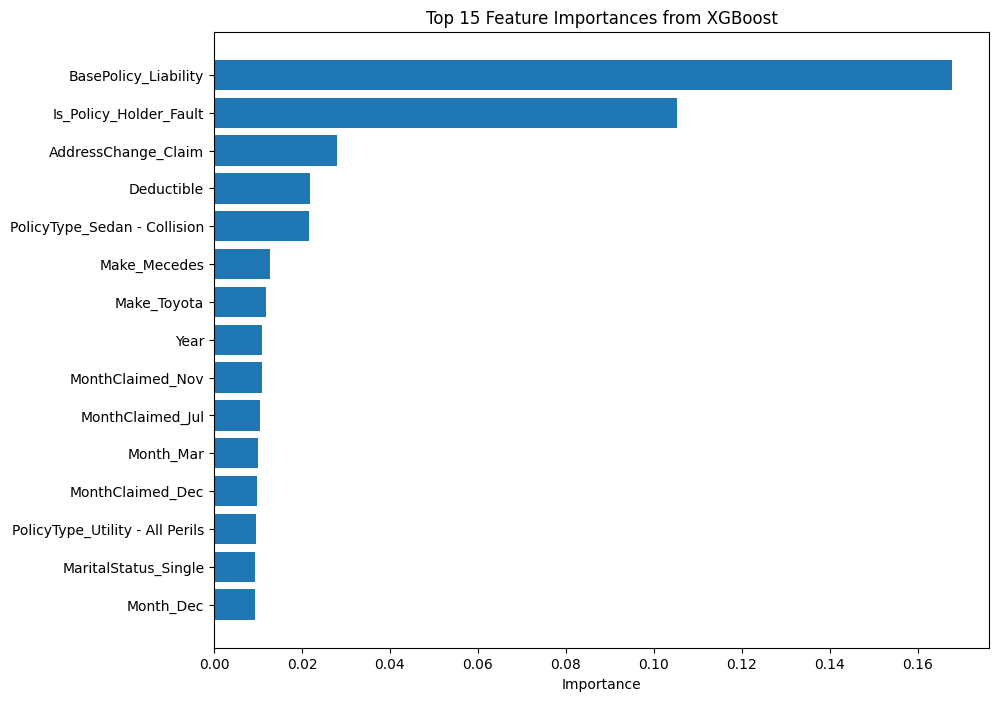

In [50]:
# Feature importance analysis
feature_importances = best_xgb_model_custom.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 15 features by importances and remove those that are not as important
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'].iloc[:15], features_df['Importance'].iloc[:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances from XGBoost')
plt.gca().invert_yaxis()
plt.show()

100%|===================| 9233/9251 [02:49<00:00]        

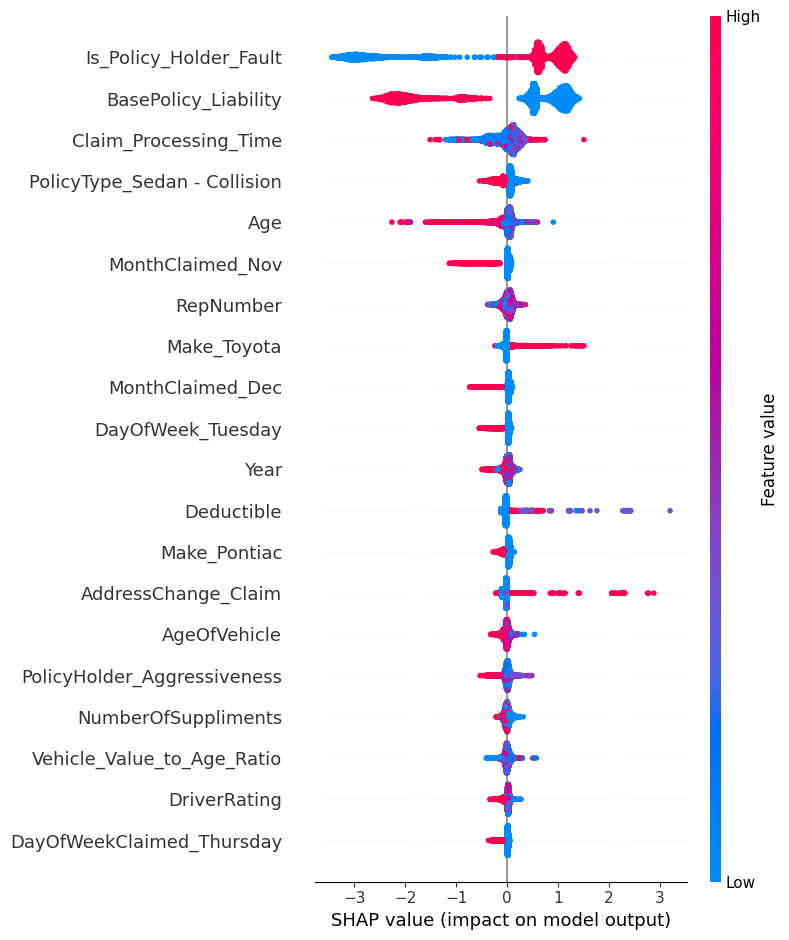

In [51]:
# Convert all bool columns to int
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})

# Generate SHAP explainer
explainer = shap.TreeExplainer(best_xgb_model_custom, data=X_train)
shap_values = explainer.shap_values(X_train)

# Plot feature importance
shap.summary_plot(shap_values, X_train)

## Making Predictions on the Test Set

In [52]:
# Retrieve the best parameters from GridSearchCV
best_params = grid_search_xgb_custom.best_params_

# Combine train and validation sets
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Calculate class weights
class_0_weight = 1
class_1_weight = len(y_final_train[y_final_train == 0]) / len(y_final_train[y_final_train == 1])
sample_weights = y_final_train.map({0: class_0_weight, 1: class_1_weight})

# Initialize the final XGBoost model with the best parameters
final_xgb_model_custom = XGBClassifier(
    random_state=42,
    scale_pos_weight=class_1_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    **grid_search_xgb_custom.best_params_
)

# Train the final model with sample weights
final_xgb_model_custom.fit(X_final_train, y_final_train)

# Align test columns with train columns
X_test = X_test.reindex(columns=X_final_train.columns, fill_value=0)

# Predict probabilities for the test set
test_predictions = final_xgb_model_custom.predict_proba(X_test)[:, 1]

c:\Users\Chen Xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Evaluation of Model Performances

In [ ]:
# Convert predicted probabilities to binary predictions
binary_predictions = (test_predictions >= 0.5).astype(int) # Vary from 0.1 to 0.5 

# Calculate AUC/ROC
auc_roc = roc_auc_score(y_test, test_predictions)

# Calculate Precision
precision = precision_score(y_test, binary_predictions)

# Calculate Recall
recall = recall_score(y_test, binary_predictions)

# Calculate F1-Score
f1 = f1_score(y_test, binary_predictions)

# Calculate Accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Calculate Precision-Recall Curve and PR AUC
precisions, recalls, thresholds = precision_recall_curve(y_test, test_predictions)
pr_auc = auc(recalls, precisions)

# Print Results
print("Confusion Matrix:\n", conf_matrix)
print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC/ROC:", auc_roc)
print("Precision-Recall AUC:", pr_auc)

Confusion Matrix:
 [[2384  501]
 [  68  131]]

Accuracy: 0.8154993514915694
Precision: 0.20727848101265822
Recall: 0.6582914572864321
F1-Score: 0.31528279181708785
AUC/ROC: 0.8496120115307909
Precision-Recall AUC: 0.24925300204278217
